In [23]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [24]:


SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



## Data
All data collected is from ERA5 Reanalysis for 2018

In [25]:
T = []
S = []
H = []
Hsw = []
Hlw = []
for i in range(3):
    T.append(xr.open_dataset('ERA5/T'+str(90-10*i))['t'])
    S.append(xr.open_dataset('ERA5/Sol'+str(90-10*i))['tisr'])
    H.append(xr.open_dataset('ERA5/htr_inp'+str(90-10*i)+'.nc')['avg_ttpm']*86400)
    Hsw.append(xr.open_dataset('ERA5/htrsw_inp'+str(90-10*i)+'.nc')['avg_ttswr']*86400)
    Hlw.append(xr.open_dataset('ERA5/htrlw_inp'+str(90-10*i)+'.nc')['avg_ttlwr']*86400)

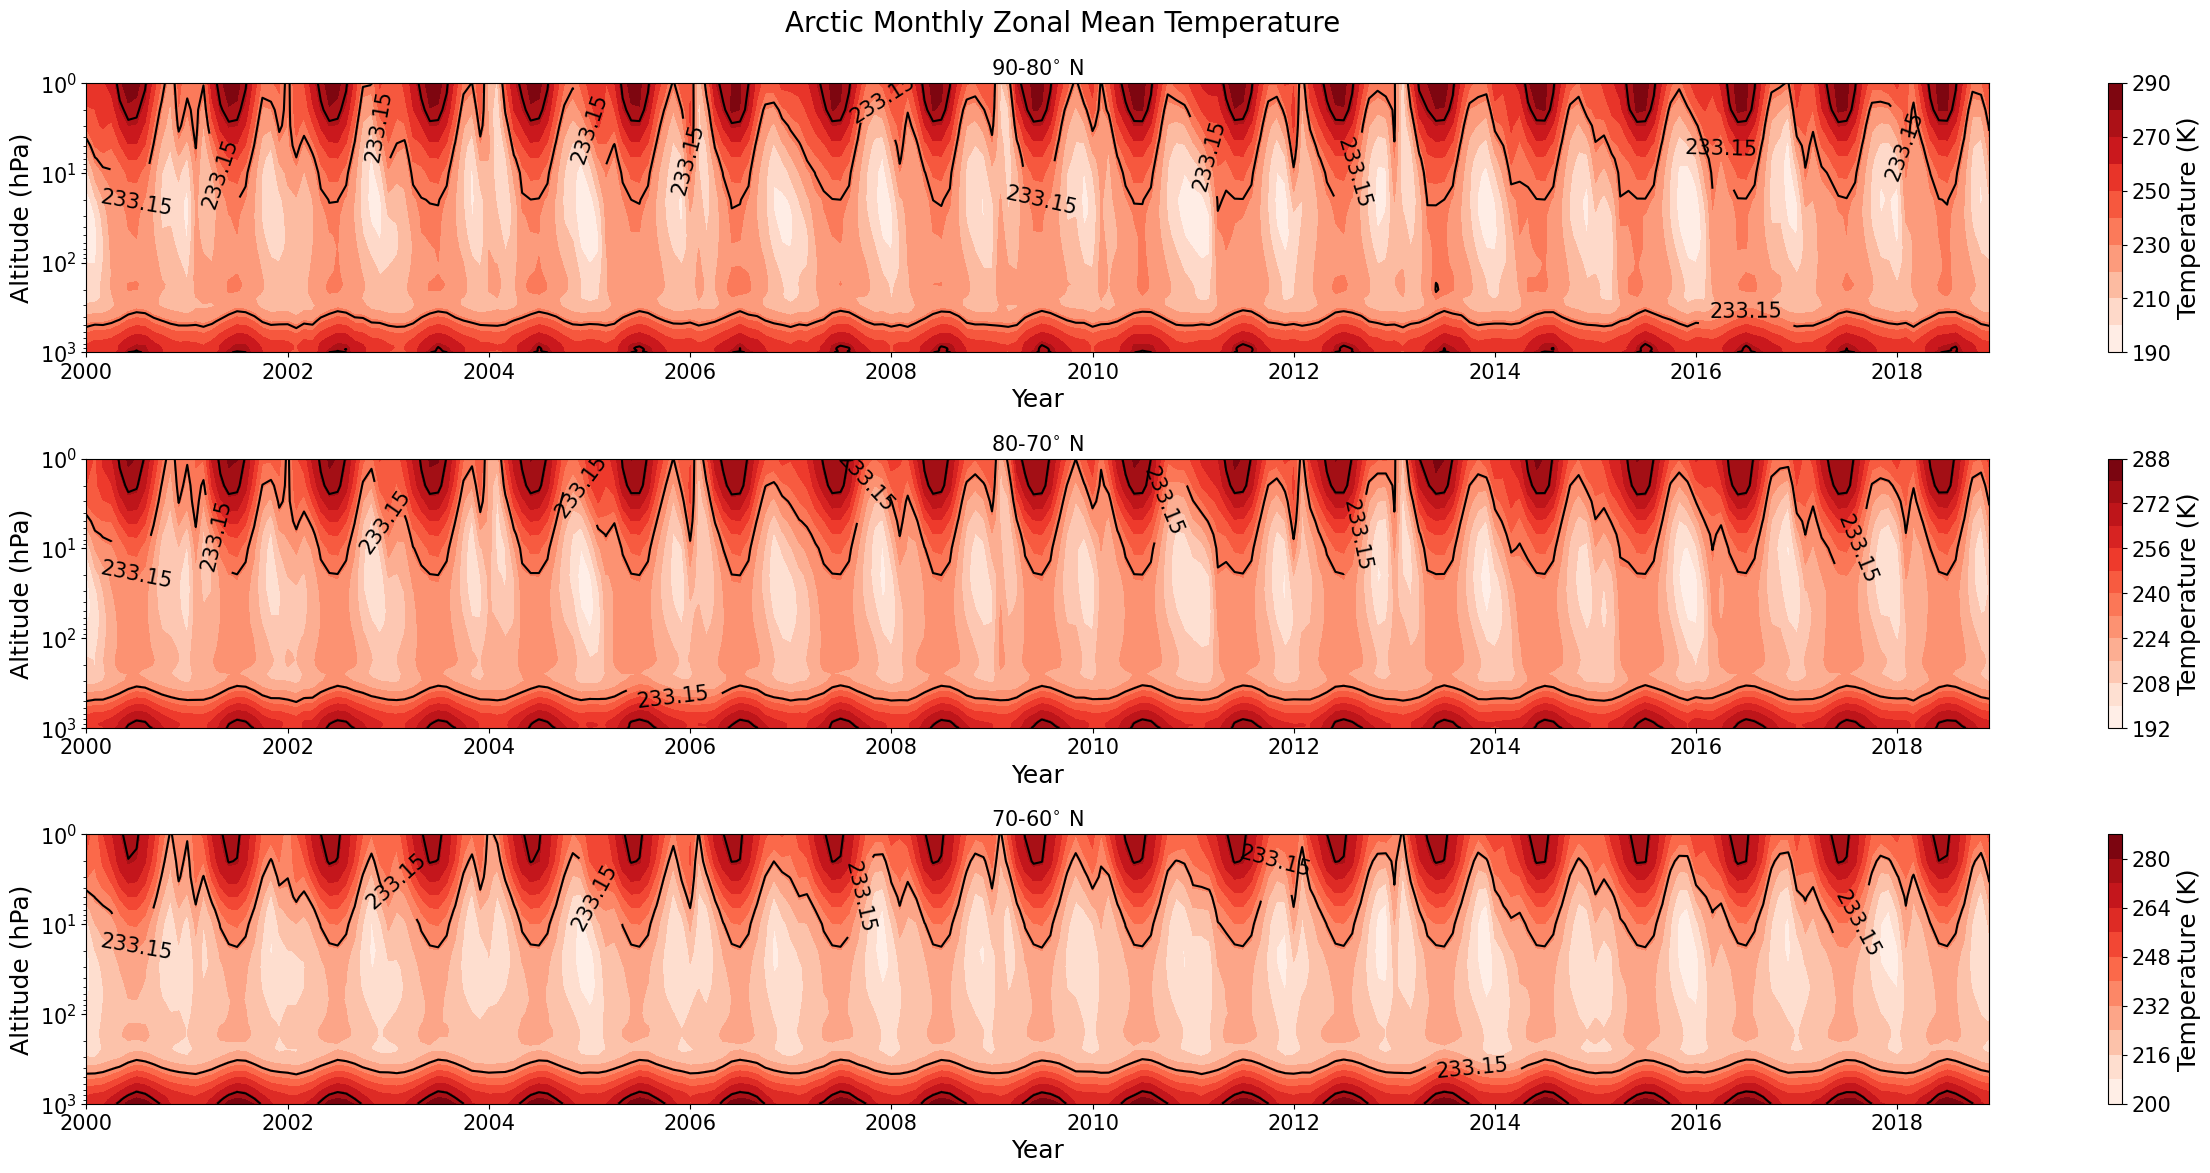

In [26]:
fig, ax =  plt.subplots(3, 1, figsize=(25,12))
fig.suptitle('Arctic Monthly Zonal Mean Temperature', x=0.43)
for i in range(3):
    cs = ax[i].contourf(T[i]['month_period'], T[i]['level'], T[i].transpose('level', 'month_period'), cmap='Reds', levels = 10)
    cs2 = ax[i].contour(T[i]['month_period'], T[i]['level'], T[i].transpose('level', 'month_period'), levels=[233.15, 273.15], colors='black', linewidths=1.5)
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel('Altitude (hPa)')
    ax[i].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Temperature (K)', ax=ax[i])
    ax[i].clabel(cs2)
    ax[i].invert_yaxis()
    
plt.tight_layout()
fig.savefig('Plots_ERA5/Mean_T_decadal.png', bbox_inches='tight')

 



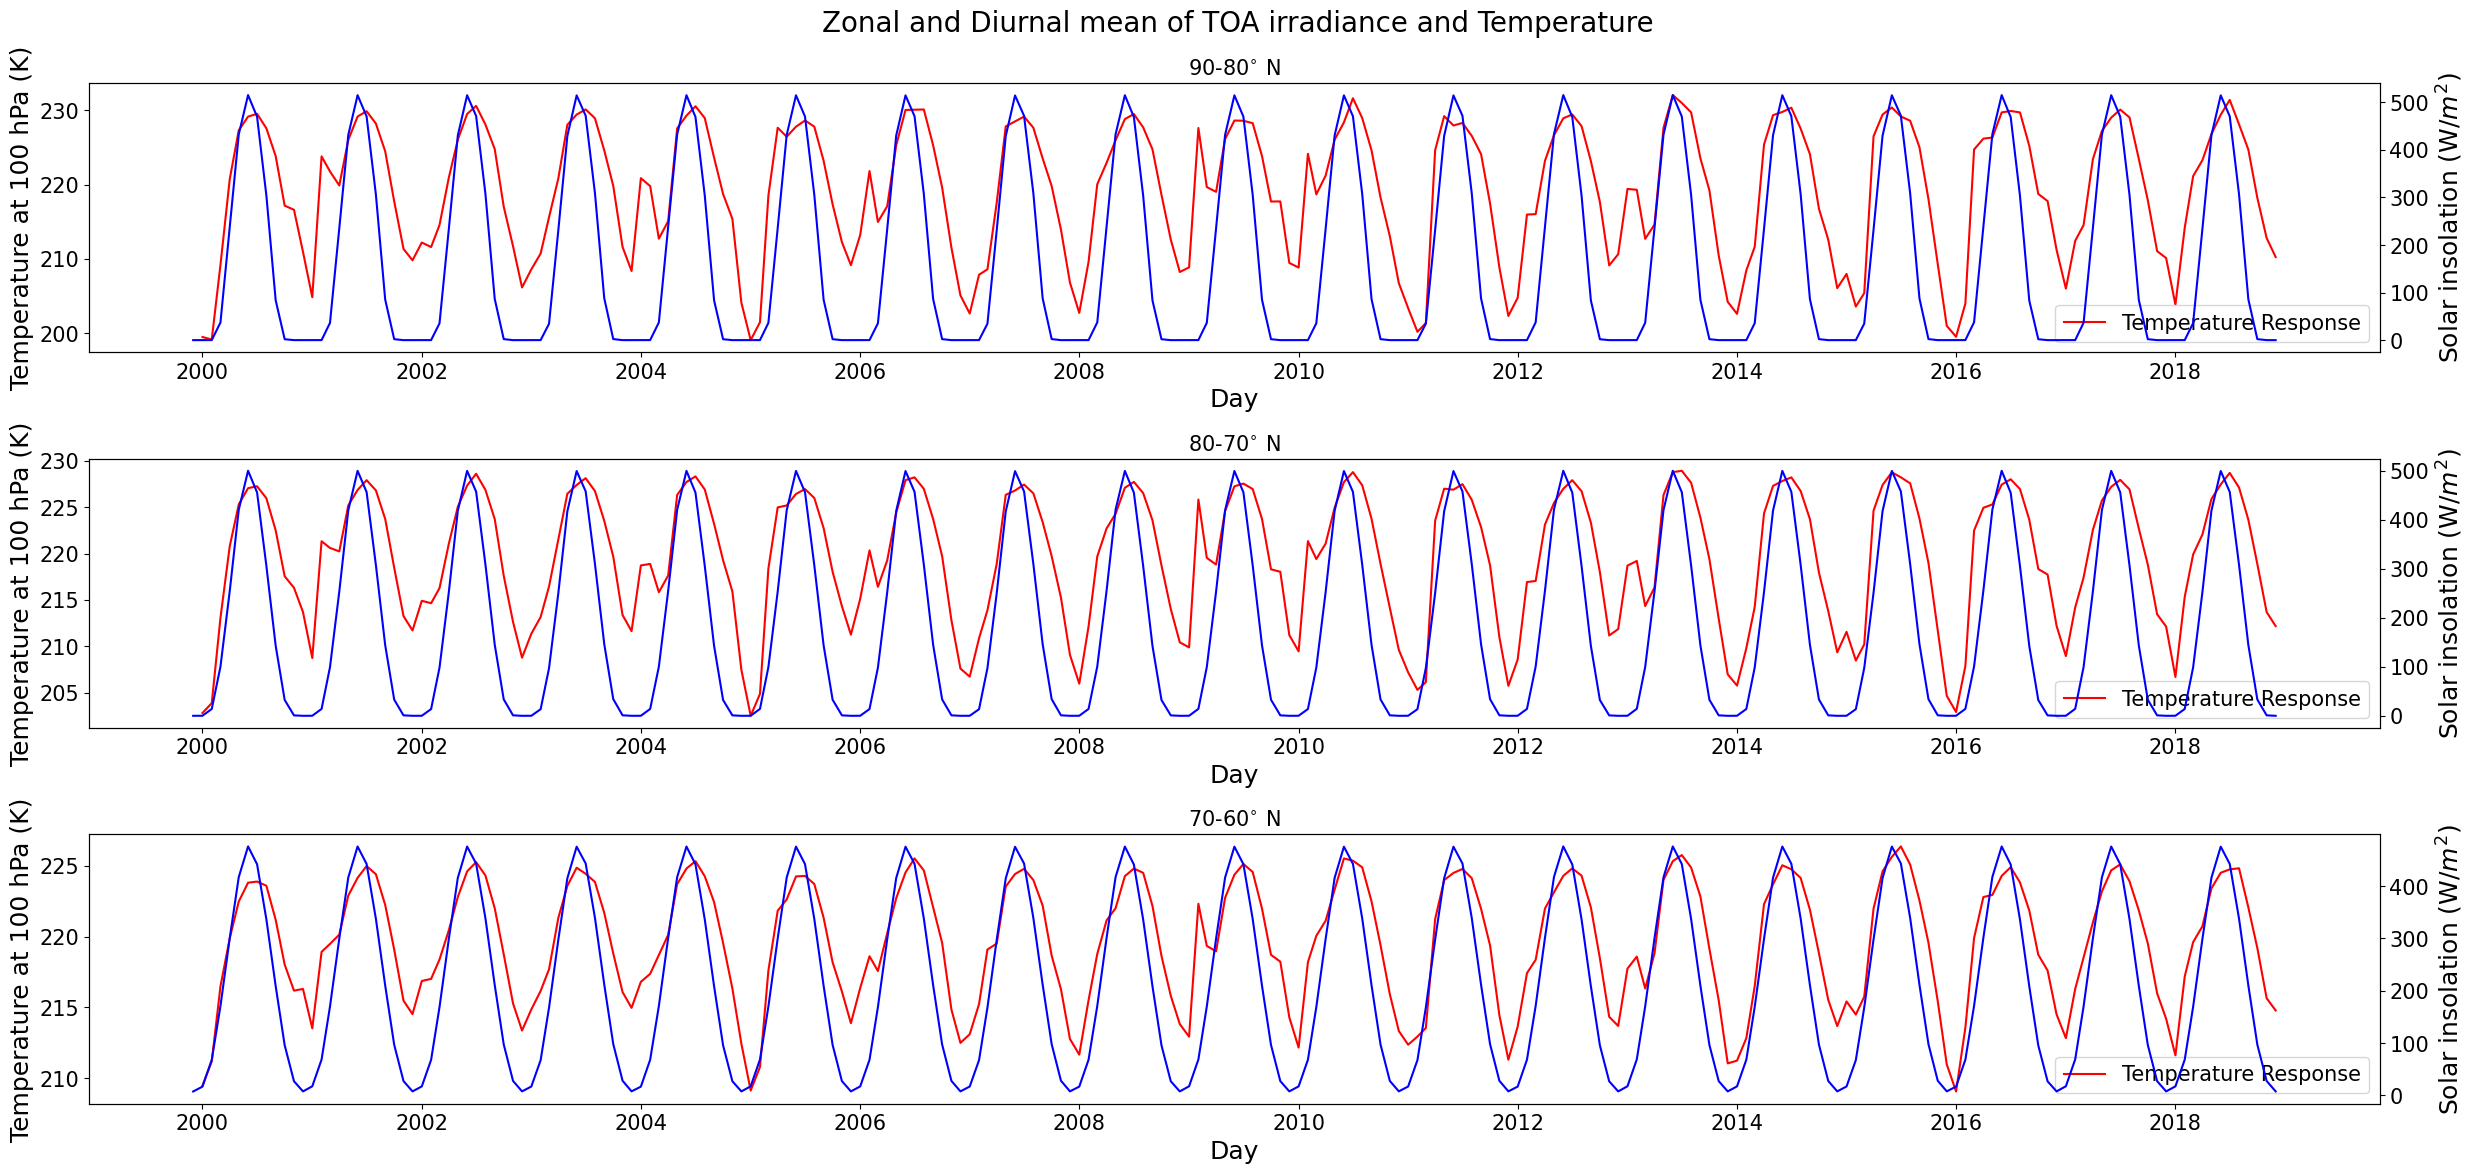

In [55]:
fig, ax =  plt.subplots(3,1, figsize=(25, 12))
fig.suptitle('Zonal and Diurnal mean of TOA irradiance and Temperature', x=0.5)
lev = 100
for i in range(3):
    ax2 = ax[i].twinx()
    ax[i].plot(T[i]['month_period'], T[i].sel(level=slice(lev, lev)), label='Temperature Response', color='red')
    ax2.plot(S[i]['month_period'], S[i]/3600, color='blue')
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Temperature at '+str(lev)+' hPa (K)')
    ax2.set_ylabel('Solar insolation (W/$m^2$)')
    # plt.xticks(np.arange(1,12,1))
    ax[i].set_title(''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    ax[i].legend()
plt.tight_layout()
fig.savefig('Plots_ERA5/T'+str(lev)+'.png')

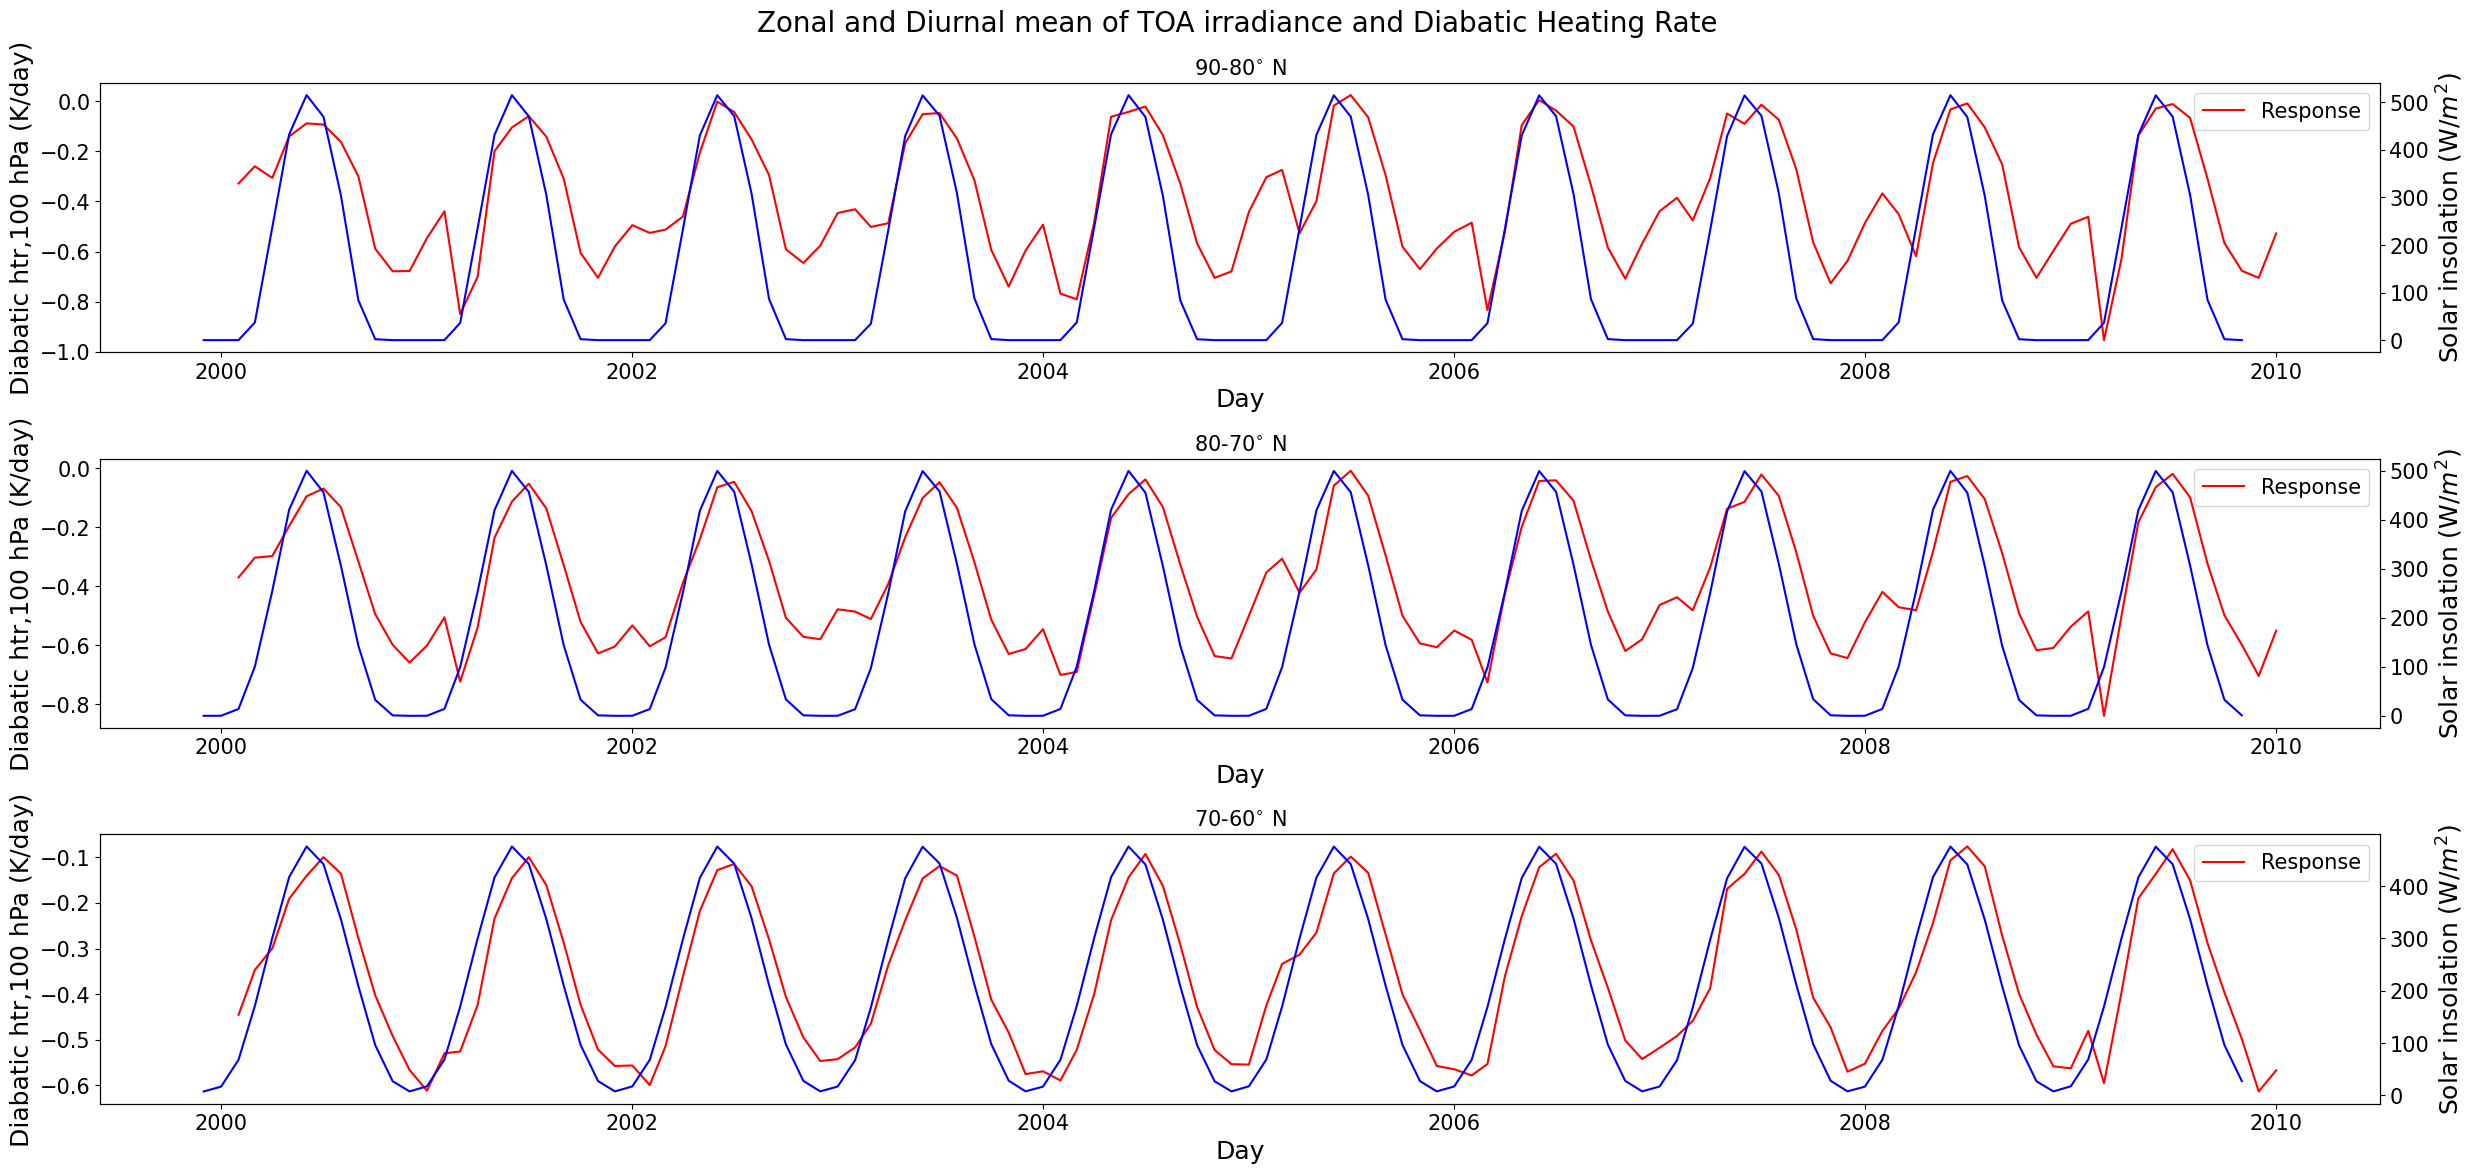

In [56]:
fig, ax =  plt.subplots(3,1, figsize=(25, 12))
fig.suptitle('Zonal and Diurnal mean of TOA irradiance and Diabatic Heating Rate', x=0.5)
for i in range(3):
    temp = S[i][:120]
    ax2 = ax[i].twinx()
    ax[i].plot(H[i]['time'], H[i].sel(level=lev), label='Response', color='red')
    ax2.plot(temp['month_period'], temp/3600, color='blue')
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Diabatic htr,'+str(lev)+' hPa (K/day)')
    ax2.set_ylabel('Solar insolation (W/$m^2$)')
    # plt.xticks(np.arange(1,12,1))
    ax[i].set_title(''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    ax[i].legend()
plt.tight_layout()
fig.savefig('Plots_ERA5/htr'+str(lev)+'.png')

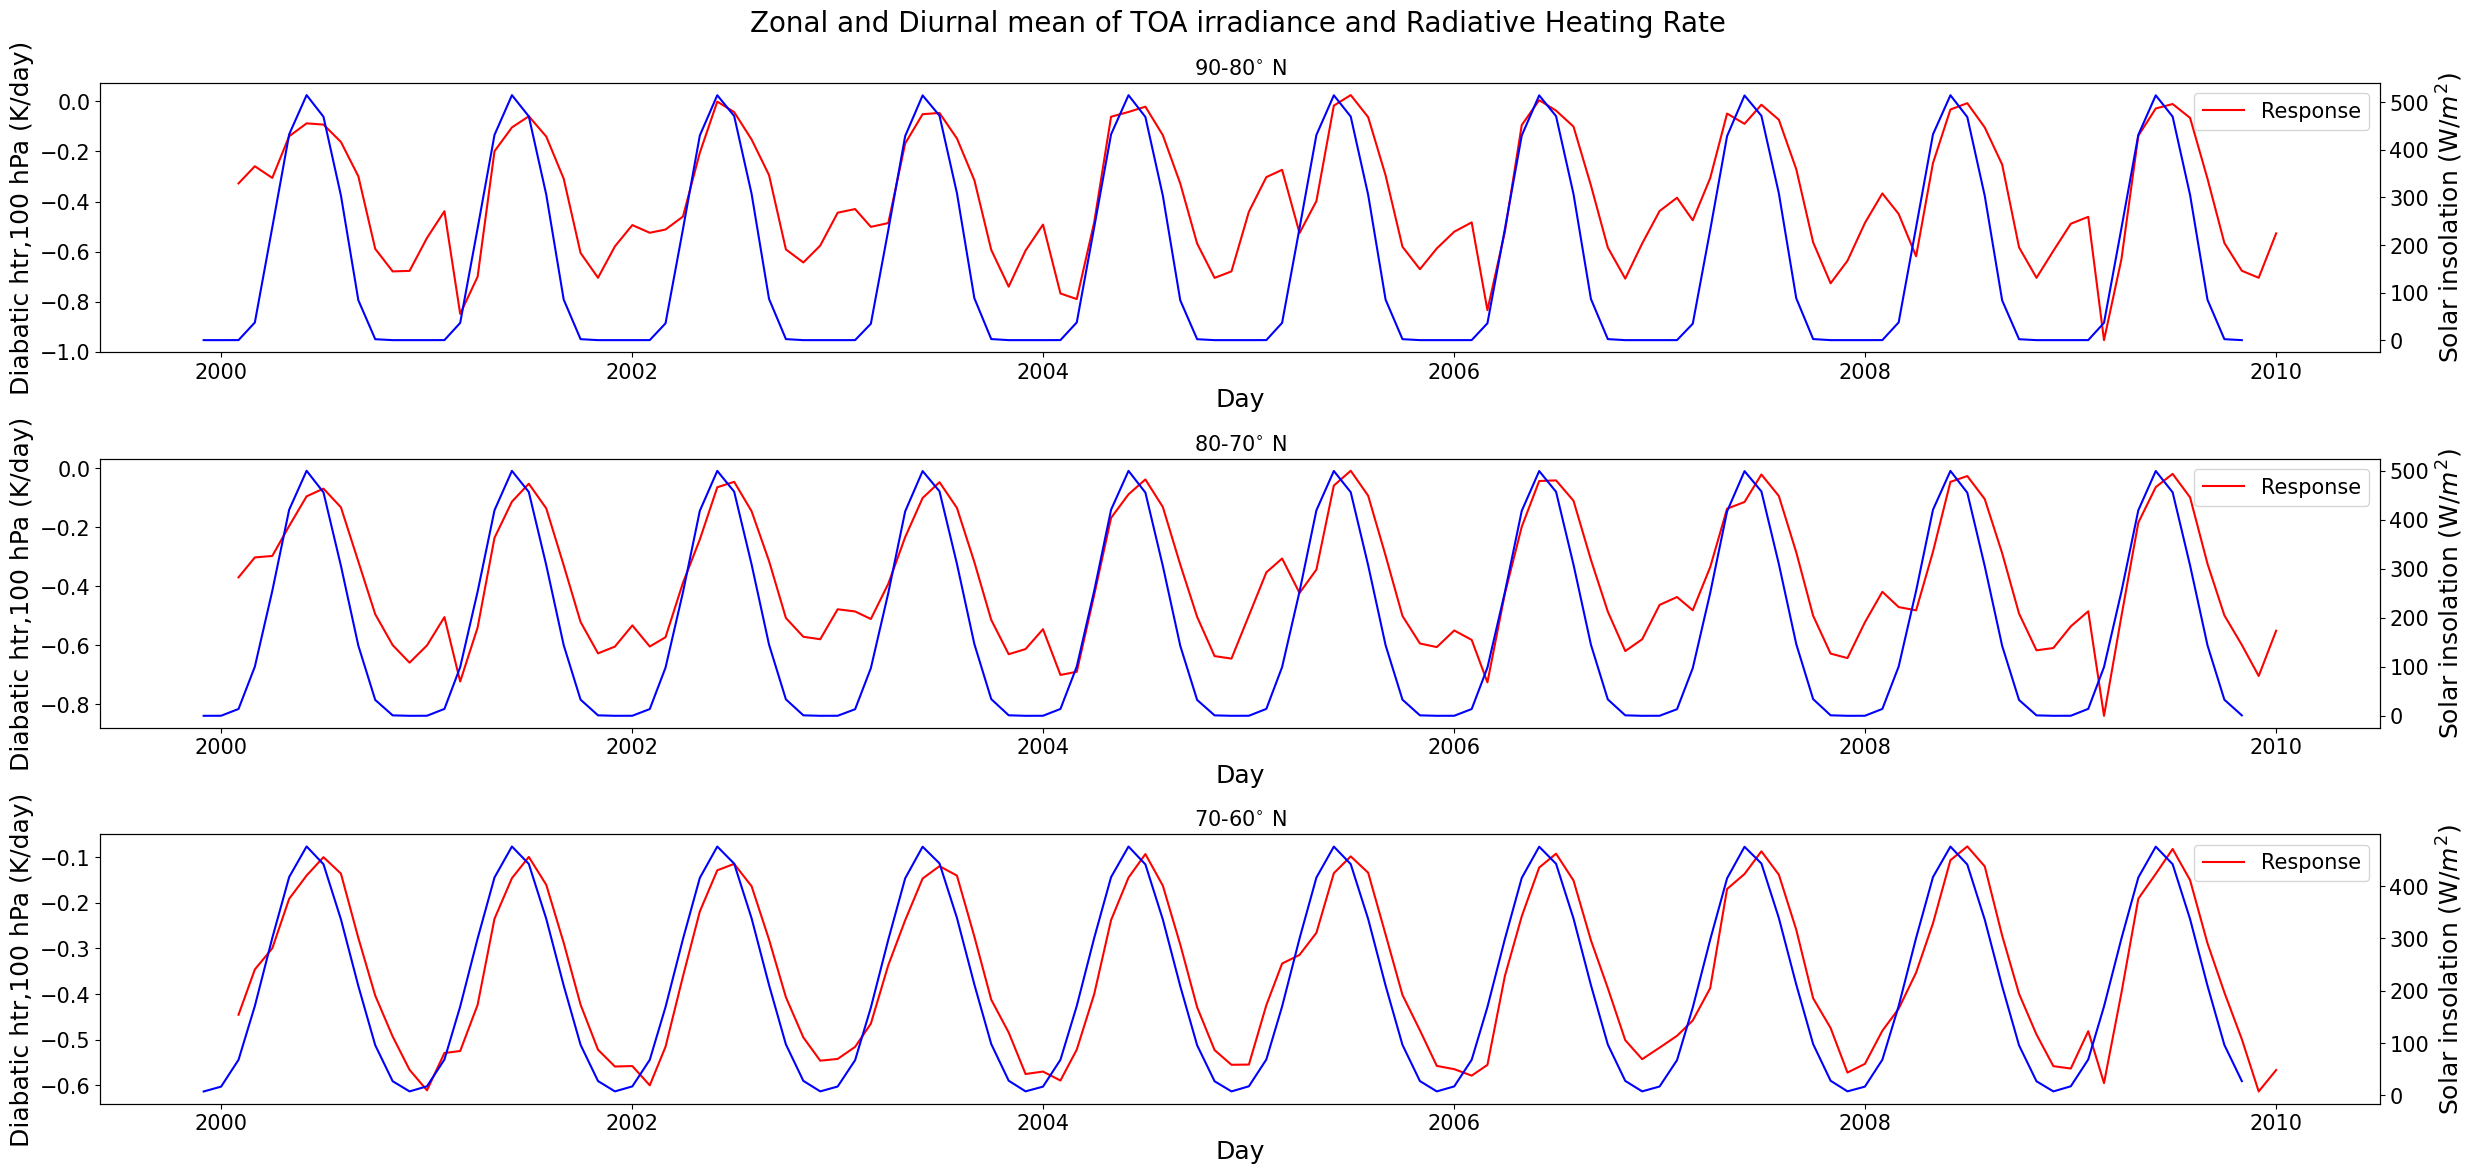

In [58]:
fig, ax =  plt.subplots(3,1, figsize=(25, 12))
fig.suptitle('Zonal and Diurnal mean of TOA irradiance and Radiative Heating Rate', x=0.5)
for i in range(3):
    temp = S[i][:120]
    ax2 = ax[i].twinx()
    ax[i].plot(H[i]['time'], (Hlw[i]+Hsw[i]).sel(level=lev), label='Response', color='red')
    ax2.plot(temp['month_period'], temp/3600, color='blue')
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Diabatic htr,'+str(lev)+' hPa (K/day)')
    ax2.set_ylabel('Solar insolation (W/$m^2$)')
    # plt.xticks(np.arange(1,12,1))
    ax[i].set_title(''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    ax[i].legend()
plt.tight_layout()
fig.savefig('Plots_ERA5/htrnonrad'+str(lev)+'.png')

In [50]:
def compute_lagged_correlation(insolation, temperature, max_lag=6):
    """
    Compute lagged correlation between insolation and temperature.
    Parameters:
        insolation (xr.DataArray): 1D time series
        temperature (xr.DataArray): 1D time series (same time length as insolation)
        max_lag (int): maximum months to shift forwards and backwards
    Returns:
        lags (list): list of lag values
        correlations (list): correlation at each lag
    """
    assert insolation.shape[0] == temperature.shape[0], "Time dimensions must match"

    lags = range(-max_lag, max_lag + 1)
    correlations = []

    # Standardize
    ins = (insolation - insolation.mean()) / insolation.std()
    temp = (temperature - temperature.mean()) / temperature.std()

    for lag in lags:
        if lag < 0:
            shifted_temp = temp[-lag:]
            valid_ins = ins[:lag]
        elif lag > 0:
            shifted_temp = temp[:-lag]
            valid_ins = ins[lag:]
        else:
            shifted_temp = temp
            valid_ins = ins

        corr = pearsonr(valid_ins, shifted_temp)[0]
        correlations.append(corr)

    return list(lags), correlations

def plot_lag_correlation(lags, correlations, i, name):
    plt.figure(figsize=(8, 4))
    plt.plot(lags, correlations, marker='o')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title('Lead-Lag Correlation for '+str(90-10*i)+'$^{\circ}$ to '+str(80-10*i)+'$^{\circ}$ : '+name+' vs Solar Insolation')
    plt.xlabel('Lag (months) [negative = '+name+' lags]')
    plt.ylabel('Pearson Correlation')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Plots_ERA5/'+name+str(90-10*i)+'.png', bbox_inches='tight')
     
# Example usage
# Assuming `insolation` and `temperature` are loaded xarray.DataArrays
# insolation: (time,)
# temperature: (level, time)

def run_analysis(insolation: xr.DataArray, temperature: xr.DataArray, i, name):
    temp_1000 = temperature.sel(level=200, method='nearest')

    lags, corrs = compute_lagged_correlation(insolation, temp_1000)
    plot_lag_correlation(lags, corrs, i, name)

    max_corr_idx = np.argmax(corrs)
    best_lag = lags[max_corr_idx]
    print(f"Maximum correlation = {corrs[max_corr_idx]:.3f} at lag = {best_lag} months")

    return best_lag, corrs[max_corr_idx]

Maximum correlation = 0.837 at lag = -1 months
Maximum correlation = 0.858 at lag = -1 months
Maximum correlation = 0.886 at lag = -1 months
Maximum correlation = 0.835 at lag = 2 months
Maximum correlation = 0.891 at lag = 3 months
Maximum correlation = 0.902 at lag = 4 months
Maximum correlation = 0.839 at lag = 2 months
Maximum correlation = 0.889 at lag = 3 months
Maximum correlation = 0.901 at lag = 3 months
Maximum correlation = 0.419 at lag = 4 months
Maximum correlation = 0.673 at lag = 5 months
Maximum correlation = 0.784 at lag = 6 months


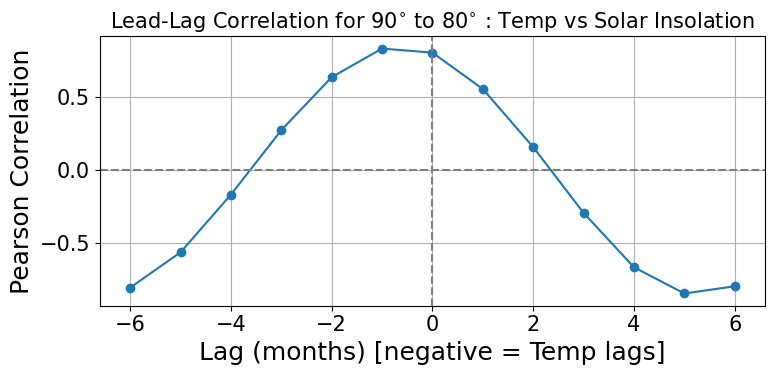

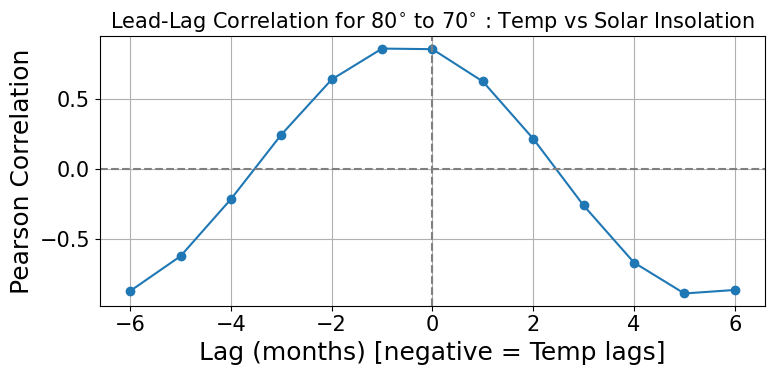

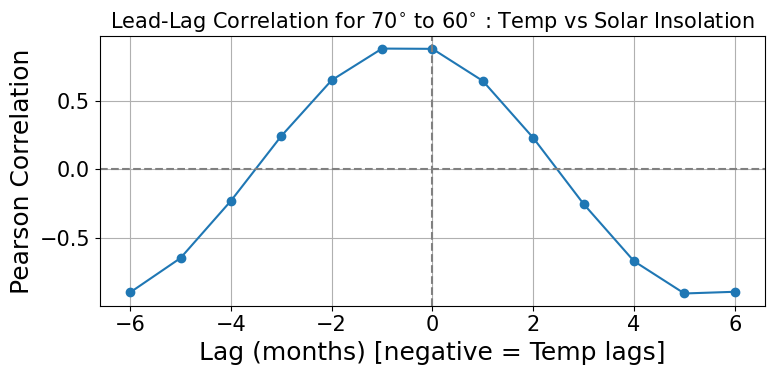

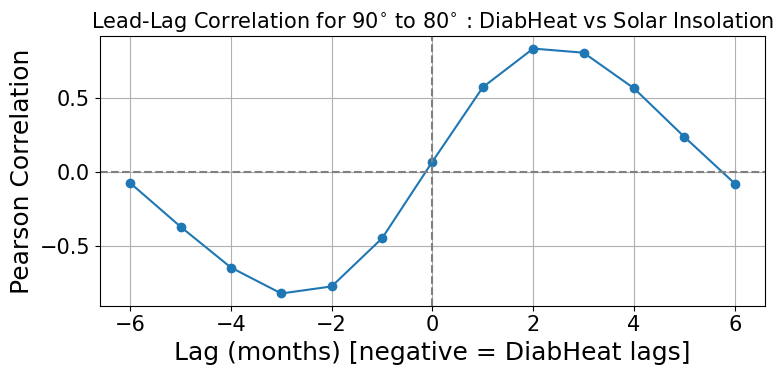

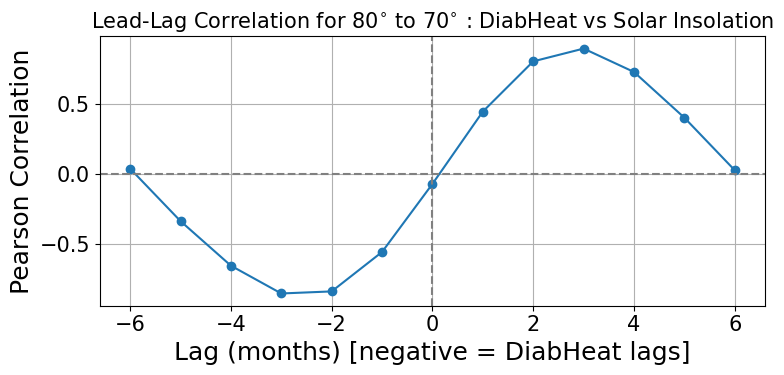

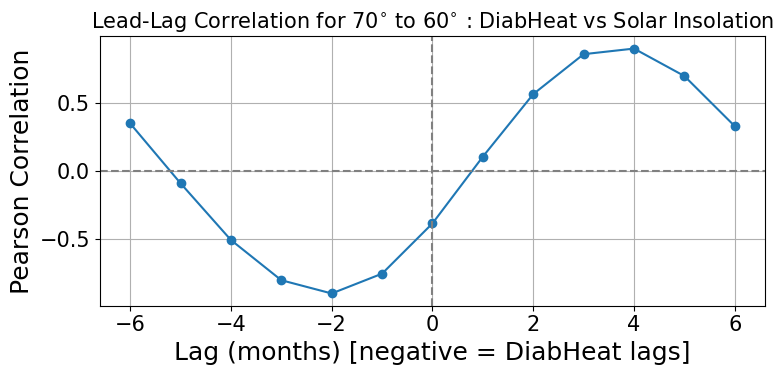

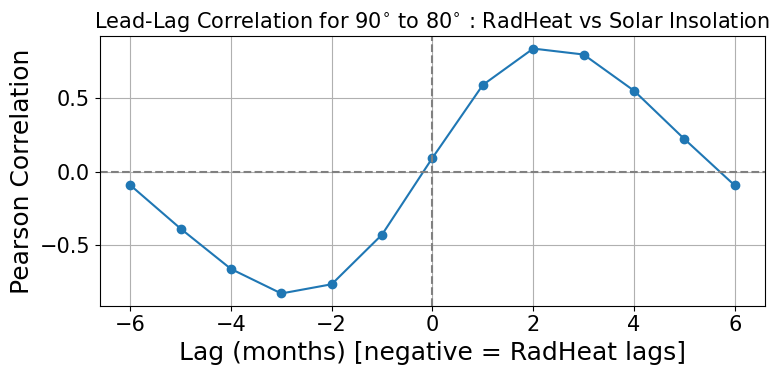

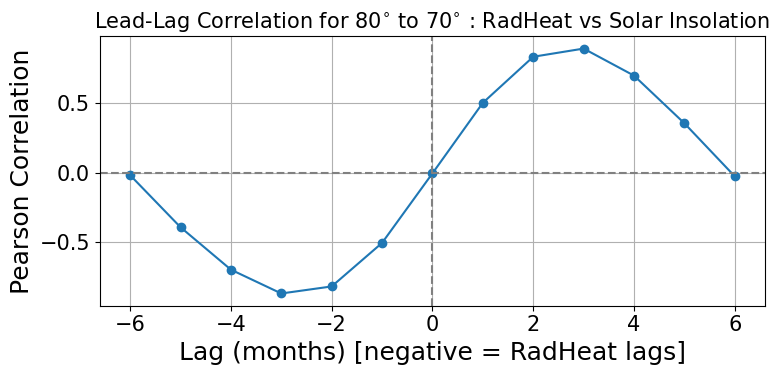

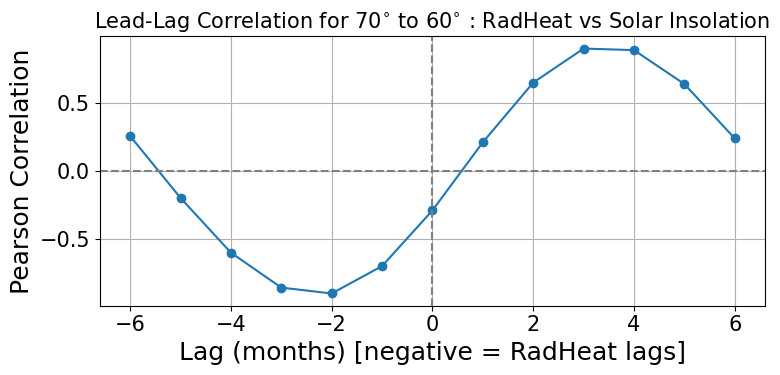

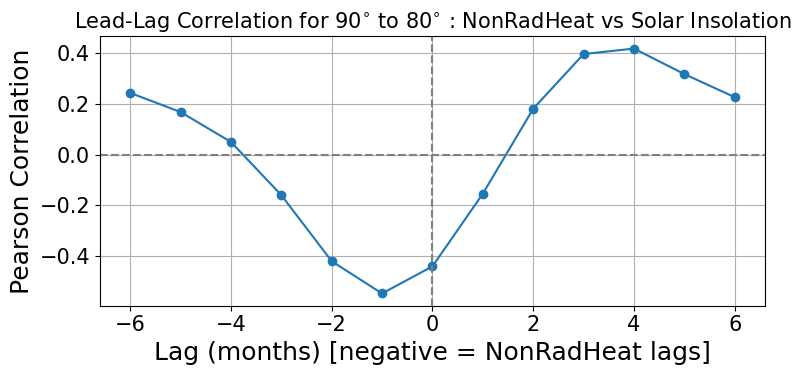

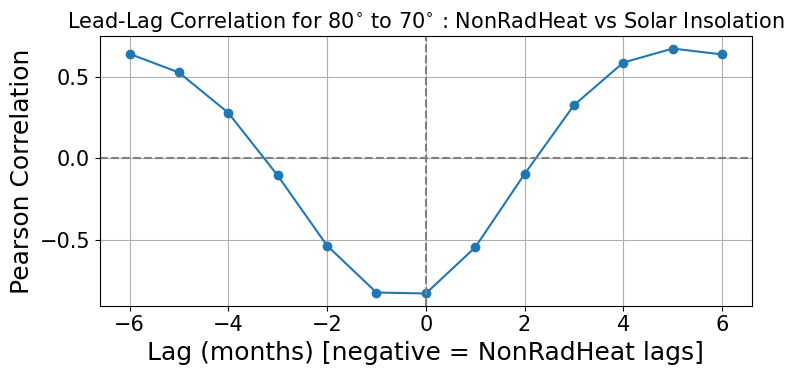

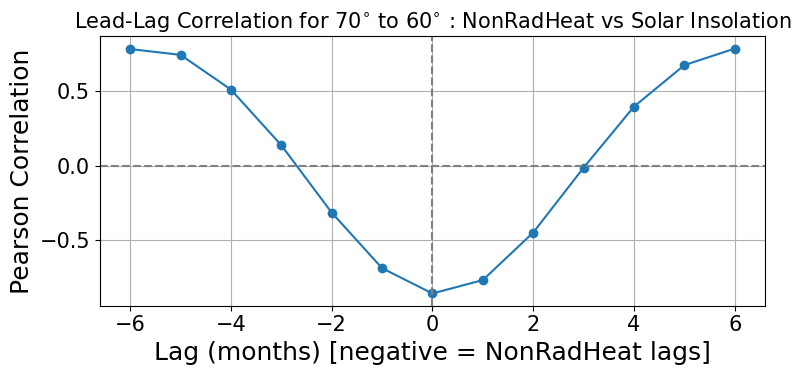

In [51]:
for i in range(3):
    run_analysis(S[i][1:], T[i], i, 'Temp')
for i in range(3):    
    run_analysis(S[i][:120], H[i], i, 'DiabHeat')
for i in range(3):
        run_analysis(S[i][:120], Hlw[i]+Hsw[i], i,'RadHeat')
for i in range(3):
        run_analysis(S[i][:120], H[i]-(Hlw[i]+Hsw[i]), i,'NonRadHeat')

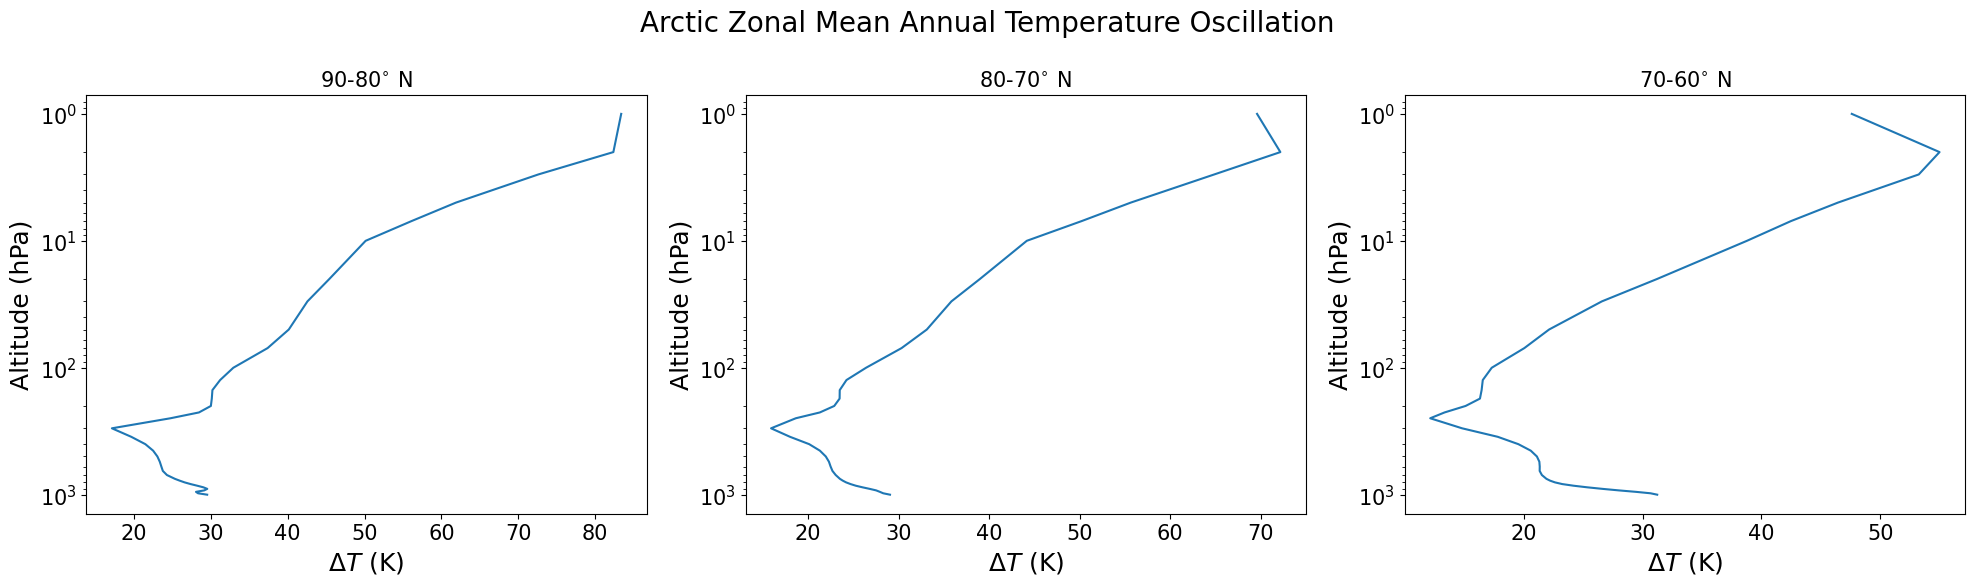

In [11]:
fig, ax =  plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Arctic Zonal Mean Annual Temperature Oscillation')
for i in range(3):
    cs = ax[i].plot(T[i].max(dim='month_period')-T[i].min(dim='month_period'), T[i]['level'])
    ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$\Delta T$ (K)')
    ax[i].set_ylabel('Altitude (hPa)')
    ax[i].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    ax[i].invert_yaxis()
    
plt.tight_layout()
fig.savefig('Plots_ERA5/T_osci.png')

## Computing Zone of Inversion

In [12]:
def comp_inv_zone(T):
    dictx = {}
    for month in range(len(T['month_period'][:60])):
       for i in range(-2,-37,-1):
            if T[month,i+1]<T[month,i] and T[month,i-1]>T[month,i]:
                temp = T[month,i]['level']
                break

       key = pd.to_datetime(T[month]['month_period'].data).to_pydatetime() 
       dictx[key] = temp
    return dictx





In [13]:
T[0][1]['month_period']

<xarray.DataArray 'month_period' ()> Size: 8B
array('2000-02-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    month_period  datetime64[ns] 8B 2000-02-01

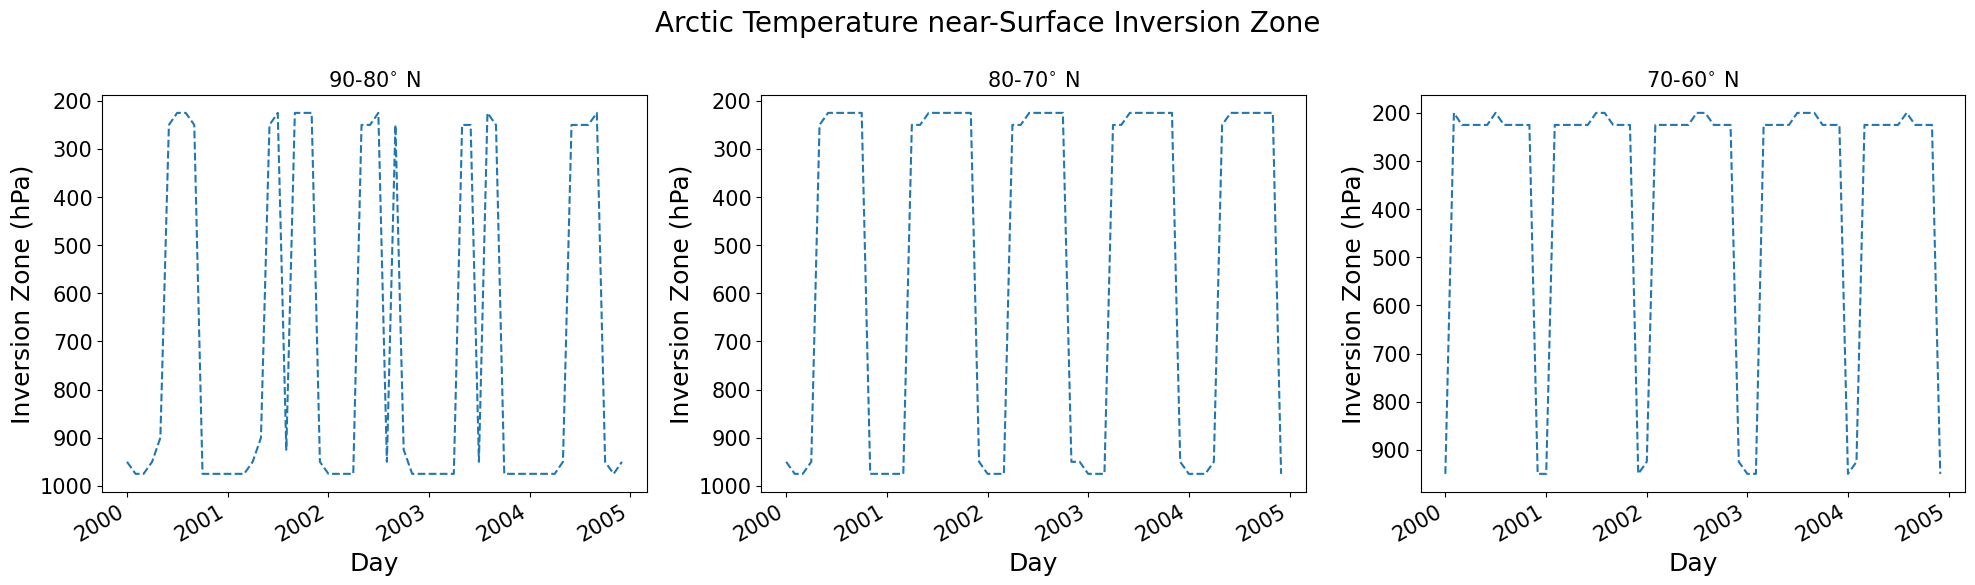

In [14]:
fig, ax =  plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Arctic Temperature near-Surface Inversion Zone')
for i in range(3):
    val = comp_inv_zone(T[i])
    cs = ax[i].plot(val.keys(), val.values(),linestyle='--')
    # ax[i].set_yscale('log')
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Inversion Zone (hPa)')
    ax[i].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    ax[i].invert_yaxis()
fig.autofmt_xdate()
plt.tight_layout()
fig.savefig('Plots_ERA5/T_inv.png')